In [1]:
#meta 5/16/2022 ARIMA Model for Time Series Forecasting in Python
#based on initial tutorial by Jason Brownlee 
#src https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

#run my WLaptop
#infra: my WLaptop w/ data in csv file
#default py3 env
#pandas 1.0.3, joblib 0.14.1, numpy 1.21.0

#started from tutorial_ARIMA_TimeSeriesForecasting.ipynb
#input: my_data/timeseries.csv 
#output: n/a
#$error

#history
# 5/18/2022 INITIAL TUTORIAL W/DIFF DATA
#      Same tutorial (but shorter), try diff dataset (a medium size ds further reduced)
#      if convergence $error, check model_fit.mle_retvals
#next try predict() insted of forecast()

#References
#strptime()
# refer to https://www.programiz.com/python-programming/datetime/strptime

In [2]:
import numpy as np
##np.set_printoptions(precision=4)
import pandas as pd
import time #to track performance time
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

print(pd.__version__, np.__version__)

1.0.3 1.21.0


In [3]:
#-------- GLOBAL VARS --------
plt.rcParams['figure.figsize'] = (16, 8)

CSV_PATH = "my_data/timeseries.csv"

# ARIMA Model for Time Series Forecasting
AutoRegressive Integrated Moving Average is is a class of statistical models for analyzing and forecasting time series data.  




Key aspects  
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.  
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model defined:

- p: The number of lag observations included in the model, also called the lag order.  
- d: The number of times that the raw observations are differenced, also called the degree of differencing.  
- q: The size of the moving average window, also called the order of moving average.  

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

## 0. Load dataset
Time series dataset with figures from 1991 to 2008 period.

In [4]:
# load dataset
series = pd.read_csv(CSV_PATH, header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.shape)
print(series.head())

(204,)
date
1991-07-01    3.526591
1991-08-01    3.180891
1991-09-01    3.252221
1991-10-01    3.611003
1991-11-01    3.565869
Name: value, dtype: float64


In [5]:
series.index = series.index.to_period('M')
series.head()

date
1991-07    3.526591
1991-08    3.180891
1991-09    3.252221
1991-10    3.611003
1991-11    3.565869
Freq: M, Name: value, dtype: float64

In [6]:
# Limit ds for modeling
series = series[series.index < '1999-01']
series.shape

(90,)

### 0.1 EDA

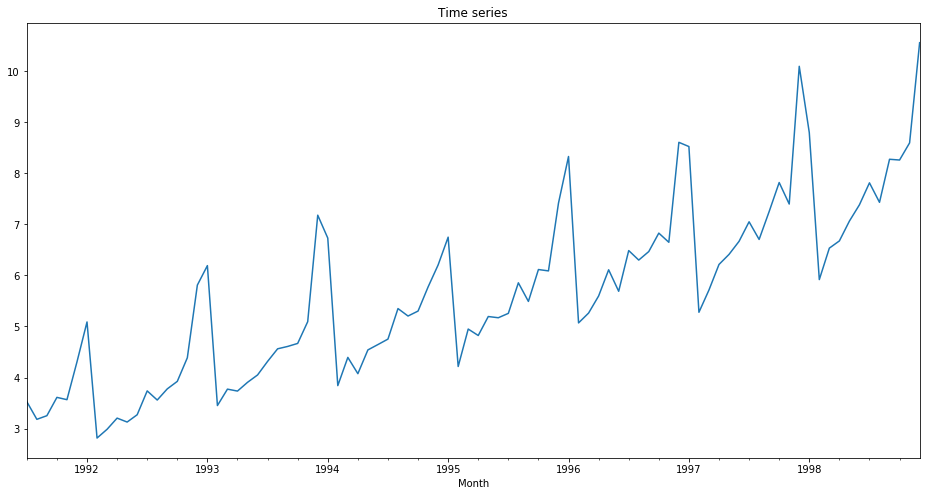

In [7]:
# vis data
series.plot(title = 'Time series')
plt.xlabel("Month")
plt.show()

The dataset has a clear trend -> Modeling: suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

##### Vis Autocorrelation

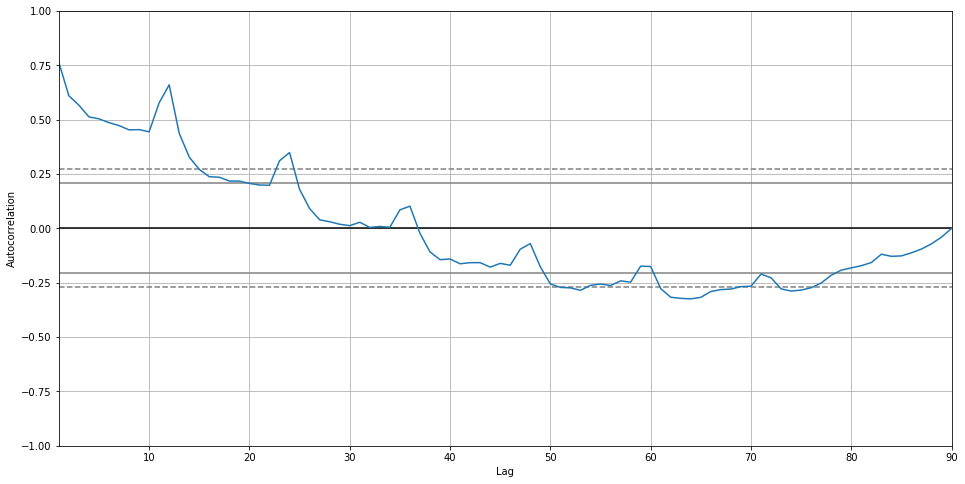

In [8]:
#plots the autocorrelation for a large number of lags in ts
autocorrelation_plot(series)
plt.show()

Plot shows a positive correlation with the first 36 lags that is perhaps significant for the first 12 lags -> Modeling: a good starting point for the AR parameter of the model may be 12.  $tolearn

## 2. How to Model
`statsmodels` library provides the capability to fit an ARIMA model.

### 2.0 Fit an ARIMA model
fit an ARIMA model to the entire dataset and review the residual errors.

`ARIMA(p,d,q)` model parameters:  
- AR set the lag value to p for autoregression  
- I use a difference order of 1 to make the time series stationary  
- MA use a moving average model of q  

In [9]:
# fit model
ORDER_P = 10
ORDER_D = 3
ORDER_Q = 12

model = ARIMA(series, order=(ORDER_P,ORDER_D,ORDER_Q))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   90
Model:               ARIMA(10, 3, 12)   Log Likelihood                 -73.195
Date:                Wed, 18 May 2022   AIC                            192.390
Time:                        19:11:25   BIC                            249.105
Sample:                    07-31-1991   HQIC                           215.227
                         - 12-31-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.5109      0.295     -8.515      0.000      -3.089      -1.933
ar.L2         -4.1283      0.823     -5.017      0.000      -5.741      -2.516
ar.L3         -5.4366      1.438     -3.782      0.0

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

##### Check model
for MLE convergence $error `ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals` 
https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

Class to hold results from fitting a state space model 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.html#statsmodels.tsa.statespace.mlemodel.MLEResults

In [10]:
model_fit.mle_retvals

{'fopt': 0.8132756283582612,
 'gopt': array([ 0.01737856,  0.05675094,  0.06626345,  0.07709939,  0.03242704,
         0.06219469,  0.02139127,  0.01744988,  0.0010502 ,  0.00314265,
         0.00032933, -0.01992452,  0.01036277,  0.02609826,  0.01365715,
        -0.00174179,  0.01399218, -0.00495494, -0.00986935,  0.00183176,
        -0.01432142,  0.01098913,  0.03739181]),
 'fcalls': 1320,
 'warnflag': 1,
 'converged': False,
 'iterations': 50}

##### Residual errors

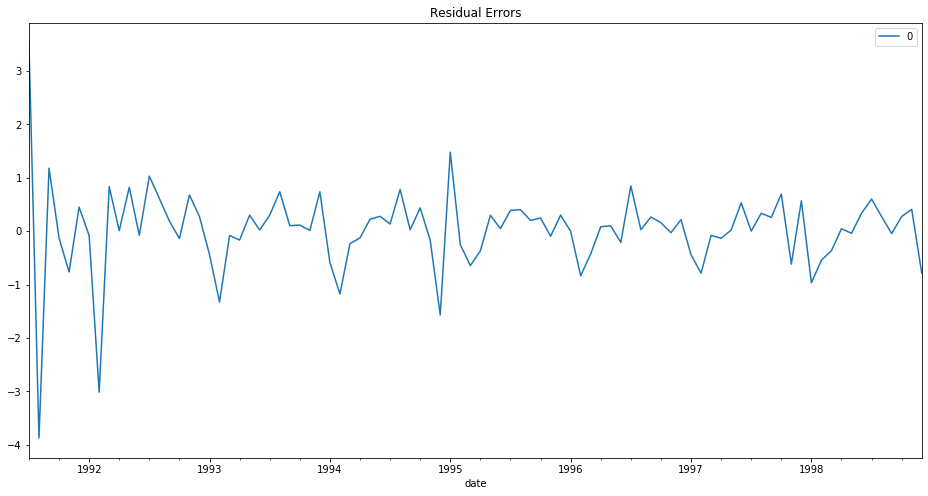

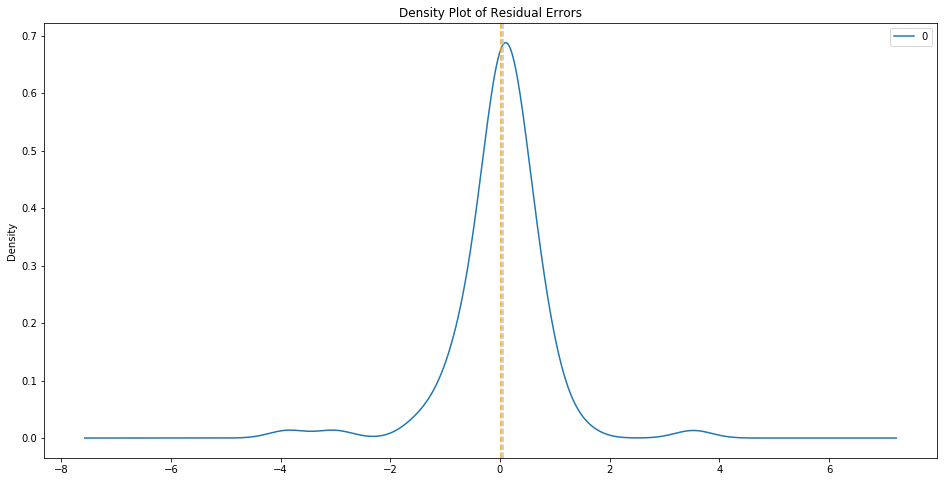

In [11]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = 'Residual Errors')
plt.show()

# density plot of residuals
residuals.plot(kind='kde', title = 'Density Plot of Residual Errors')
plt.axvline(residuals.describe().loc['mean',0], color ='orange', linestyle ='--')
plt.axvline(residuals.describe().loc['50%',0], color ='silver', linestyle ='--')
plt.show()

- Line plot of the residual errors suggests $tolearn that there may still be some trend information not captured by the model  
- Density plot of the residual errors suggests the errors are Gaussian (centered close to zero)

In [12]:
# summary stats of residuals
print(residuals.describe())

               0
count  90.000000
mean    0.016987
std     0.828228
min    -3.872295
25%    -0.168603
50%     0.046523
75%     0.325930
max     3.526591


The results show that indeed there is a close to zero mean in the residuals.

## 1. Prep data
We used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

In [13]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

print(len(train), len(test))

59 31


### 2.1 Create a Model
ARIMA modeling to make forecasts

`forecast()` function performs a one-step forecast using the model

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

In [15]:
# 1)fit the model on train ds, and 2)generate a prediction for each element on the test ds
history = [x for x in train]
predictions = list()

#track overall training time
t0 = time.time()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(ORDER_P,ORDER_D,ORDER_Q))
	model_fit = model.fit() #method_kwargs={"warn_convergence": False}
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
print("Modeling time (in min): ", (time.time() - t0)/60)

LinAlgError: Schur decomposition solver error.

##### Evaluate Model
Calculate RMSE for the predictions, providing a point of comparison for other ARIMA configurations

In [ ]:
# evaluate forecasts on test ds
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test, label = 'y')
plt.plot(predictions, color='red', label= 'y-hat')
plt.title('Rolling Forecast with ARIMA Model')
plt.legend(loc='upper left') #loc='best', handleheight = 7, 
plt.show()

Plot shows the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

The model could use further tuning of the `p`, `d`, and maybe even the `q` parameters.


##### $next Better
We can use the `predict()` function on the `ARIMAResults` object (https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html) to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as `start=101`, `end=101`. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (`d>0` when configuring the model). This can be specified by setting the `typ` argument to the value ‘levels’: `typ=’levels’`.

## Configuring an ARIMA Model
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology (https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method).  This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

## Summary
The steps of this process are:

- Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.  
- Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.  
- Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.  

The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).

References:  
How to Grid Search ARIMA Model Hyperparameters  (https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)